Using Longitudinal Data
=======================

This example demonstrates how to do cross validation with longitudinal
data.
By *longitudinal*, we mean predictors for specific samples that have more than one value. 
This could be time series data or any other sequential data we might want to model. 


Example Patient Data
------------------------------

First, we generate some example data and store it using this script: https://github.com/lacava/feat/blob/master/docs/examples/longitudinal/generate_example_longitudinal_data.py. 

Let’s imagine we have patient data from a hospital. 
This means we have measurements from different visits, with different numbers of measurements from different
patients collected in non-uniform intervals.
In this example, we make up a risk model in which risk increases for a
patient with an increasing body mass index (BMI) and a high maximum
glucose level in their blood panel.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

random_state=42

df = pd.read_csv('data/d_example_patients.csv')
df.drop('id',axis=1,inplace=True)
X = df.drop('target',axis=1)
y = df['target']
kf = KFold(n_splits=3,shuffle=True,random_state=random_state)

# longitudinal format

FEAT expects longitudinal data in the following format:

```python

Z = {
    'variable': ([patient1_values, patient2_values], [patient1_times, patient2_timestamps])
}
```


Longitudinal data is a dictionary in which the keys are the variable names and the values are tuples. 
The first element of the tuple contains observations, and the second element contains corresponding time stamps for those observations. 
The observations and timestamps are expected to be lists, with one element for each patient. 
Each patient element contains all of the observations or time stamps for that patient. 


On the c++ side, FEAT interprets this into the following format:

```c++
typedef std::map<string, 
                 std::pair<vector<Eigen::ArrayXf>, vector<Eigen::ArrayXf>>
                > LongData;
```

Although a little clunky, the goal is to store patient-specific values in arrays under the hood to allow for as much SIMD optimization as possible when evaluating operators.

Here is the longitudinal data we generated:

In [2]:
zfile = 'data/d_example_patients_long.csv'
zdf = pd.read_csv('data/d_example_patients_long.csv')
zdf

,id,name,date,value
0,0,bmi,2515,40.000000
1,0,age,2515,33.000000
2,0,glucose,2515,0.058084
3,0,bmi,2979,40.000000
4,0,age,2979,34.000000
...,...,...,...,...
147250,992,age,71187,213.000000
147251,992,glucose,71187,0.388632
147252,992,bmi,72149,87.000000
147253,992,age,72149,215.000000


As you can see it's in a long tabular format. Below we convert it to the FEAT input format.

In [3]:
dates = zdf.set_index(['name','id'])['date']
values = zdf.set_index(['name','id'])['value']
# zdf.set_index(['name','date']).to_dict(orient='tight')
values.to_dict()
Z = {}
for name, zg in zdf.groupby('name'):
    values = [
        zgid['value'].values for _,zgid in zg.groupby('id')
    ]
    timestamps = [
        zgid['date'].values for _,zgid in zg.groupby('id')
    ]
    Z[name] = (values, timestamps)
    


Next we set up the learner. We need to declare the longitudinal
operators we want to search over. They are defined as a comma-delimited
list of strings using the ``functions`` argument. In this case, the
operators on the second row of the declaration below all operate on
longitudinal data.


In [4]:
from feat import Feat

clf = Feat(max_depth=5,
           max_dim=5,
           gens = 10,
           pop_size = 100,
           max_time = 30, # seconds
           verbosity=0,
           shuffle=True,
           normalize=False, # don't normalize input data
           functions=['and','or','not','split','split_c',
                     'mean','median','max','min','variance','skew','kurtosis','slope','count'
                     ],
           backprop=True,
           batch_size=10,
           iters=10,
           random_state=random_state,
           n_jobs=1,
           simplify=0.01    # prune final representations
          )


Cross validation
----------------

Cross validation works a little bit differently with longitudinal data. 
The block below shows how to train a model using Kfold cross validation.

In [5]:
scores=[]

for train_idx, test_idx in kf.split(X,y):
    # print('train_idx:',train_idx)
    # note that the train index is passed to FEAT's fit method
    Ztrain = {k:([v[0][i] for i in train_idx], [v[1][i] for i in train_idx]) for k,v in Z.items()}
    Ztest = {k:([v[0][i] for i in test_idx], [v[1][i] for i in test_idx]) for k,v in Z.items()}
    clf.fit(X.loc[train_idx],y.loc[train_idx],Ztrain) 
    scores.append(clf.score(X.loc[test_idx],y.loc[test_idx],Ztest))

print('scores:',scores)

scores: [1.0990564495786515e-11, 4.775369117841527e-13, 2.51900467082436e-13]


Model Interpretation
--------------------

Now let’s fit a model to all the data and try to interpret it.


In [6]:
# fit to all data

print('fitting longer to all data...')
clf.gens = 100
clf.fit(X,y,Z)

fitting longer to all data...


Feat(backprop=True, batch_size=10, feature_names='sex,race',
     functions=['and', 'or', 'not', 'split', 'split_c', 'mean', 'median', 'max',
                'min', 'variance', 'skew', 'kurtosis', 'slope', 'count'],
     max_depth=5, max_dim=5, max_time=30, normalize=False, random_state=42,
     simplify=0.01)


To see the learned representation, we run ``clf.get_representation()``:

In [7]:
clf.get_representation()

'[slope(z_bmi)][max(z_glucose)]'

Here our final representation is composed of ``slope(z_bmi)`` and
``max(z_glucose)``, both of which we know to be correct features for
this simulated dataset. The best training representation displays clear
overfitting, highlighting the importance of using archive validation for
model selection.
We can also look at the representation with the model weights, sorted by
magnitude, using ``clf.get_model()``:

In [8]:
print(clf.get_model())

Weight	Feature
-1.40001	offset
1500.00	slope(z_bmi)
10.00	max(z_glucose)



View runtime stats
------------------

FEAT stores statistics about the training procedure in a dictionary `clf.stats_`. 
An example of plotting from this dictionary is shown below.

In [9]:
clf.stats_.keys()

dict_keys(['generation', 'med_complexity', 'med_dim', 'med_loss', 'med_loss_v', 'med_num_params', 'med_size', 'min_loss', 'min_loss_v', 'time'])

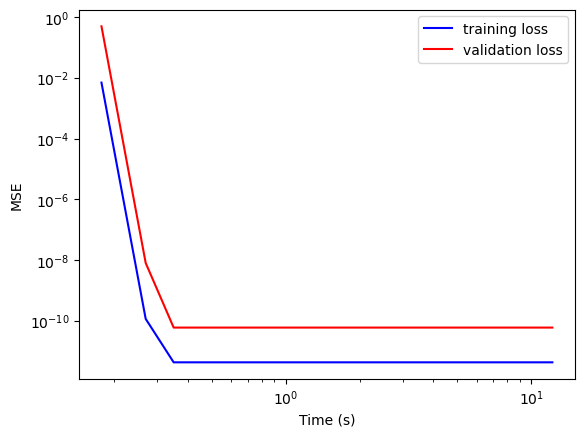

In [10]:
import matplotlib.pyplot as plt
plt.plot(clf.stats_['time'], clf.stats_['min_loss'], 'b', label='training loss')
plt.plot(clf.stats_['time'], clf.stats_['min_loss_v'], 'r', label='validation loss')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

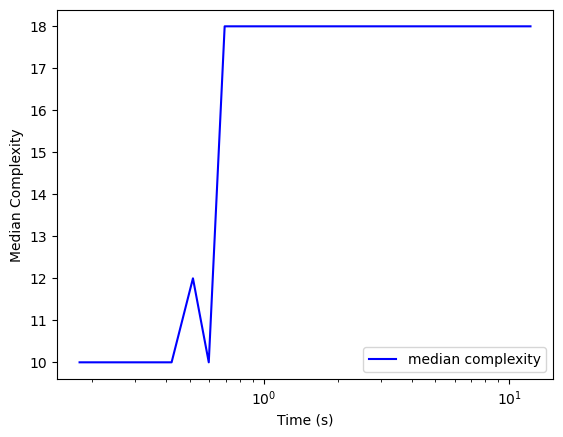

In [11]:
import matplotlib.pyplot as plt
plt.plot(clf.stats_['time'], clf.stats_['med_complexity'], 'b', label='median complexity')
# plt.plot(clf.stats_['time'], clf.stats_['med_size'], 'r', label='median size')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Median Complexity')
# plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

Visualizing the representation
------------------------------

Here we take the two relevant features and plot the data with them.
This shows us the risk surface as a function of these learned features.

proj: (993, 2)
rep: ['slope(z_bmi)', 'max(z_glucose)']


/tmp/ipykernel_11898/1426583834.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdBu')


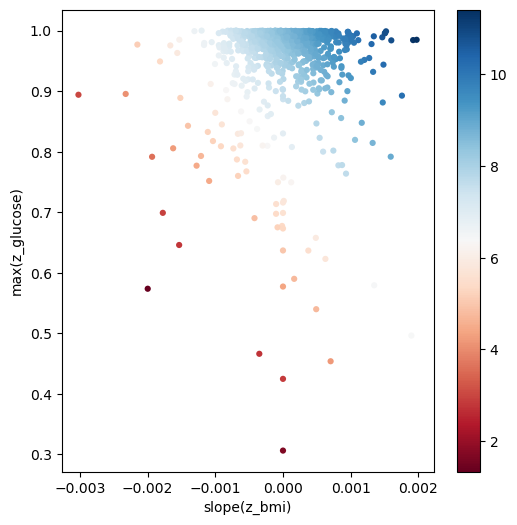

In [12]:
# Visualize the representation

proj = clf.transform(X,Z)

print('proj:',proj.shape)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from matplotlib import cm

cm = plt.cm.get_cmap('RdBu')
# We choose a color palette with seaborn.
# palette = np.array(sns.color_palette("cividis", np.unique(y)))

# We create a scatter plot.
f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(proj[:,0], proj[:,1], lw=0, s=20,
                c=y, cmap=cm)
plt.colorbar(sc)
# sc.colorbar()
ax.axis('square')
# ax.axis('off')
ax.axis('tight')

# add labels from representation
rep = [r.split('[')[-1] for r in clf.get_representation().split(']') if r != '']
print('rep:',rep)
plt.xlabel(rep[0])
plt.ylabel(rep[1])

# plt.savefig('longitudinal_representation.svg', dpi=120)
plt.show()